In [1]:
!pip install opencv-python

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/MyDrive/drawing-reconstruction/

/content/drive/MyDrive/drawing-reconstruction


In [4]:
%cd scripts/
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython.display import clear_output
def dilate_image(img, kernel_size=3, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    img = img.astype(np.uint8)
    return cv2.dilate(img, kernel, iterations=iterations)

from vae_model_classic_bernoulli import VAE
from dataset import ImageDataset

%matplotlib inline


/content/drive/MyDrive/drawing-reconstruction/scripts


In [5]:
dataset_dir = "quickdraw"
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_limit = 1000
image_size = (256, 256)
binarization_threshold = 0.5
model_weights_save_path = "weights.pth"

item = "ice cream"
latent_dim = 128
model_residual = False

config = {
    "epochs": 20000000,   # you will likely stop early
    "lr": 1e-3,
    "weight_decay": 1e-7,
    "grad_clip": 1e-1,
    "loss": VAE.loss
}


In [6]:
import cv2
def get_y(x, out):
    if model_residual:
        return torch.min(x, 1 - out)
    return out

def binarize(img):
    binary = np.ones_like(img, dtype=np.float32)
    binary[img < binarization_threshold] = 0
    return binary

def visualize(axarr, images, titles):
    for ax in axarr:
        ax.clear()
        ax.axis("off")

    for i, img in enumerate(images):
        axarr[i].imshow(img, cmap="gray")
        axarr[i].set_title(titles[i])

def save_model(model):
    torch.save(model.state_dict(), model_weights_save_path)
    print(f"Model weights saved to {model_weights_save_path}")

def dilate_image(img, kernel_size=3, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    img = img.astype(np.uint8)
    return cv2.dilate(img, kernel, iterations=iterations)


In [7]:
def eval_loss(loader, loss_fn):
    model.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for X, y_, _ in loader:
            X = X.to(device, dtype=torch.float32).unsqueeze(1)
            enc_mean, enc_logvar, dec_mean, dec_logvar = model(X)

            batch_size = X.size(0)
            loss = loss_fn(X, enc_mean, enc_logvar, dec_mean, dec_logvar)

            total_loss += loss.item() * batch_size
            total_samples += batch_size

    return total_loss / total_samples


In [8]:

def train(model, train_loader, val_loader, config):
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config["lr"],
        weight_decay=config["weight_decay"]
    )

    loss_fn = config["loss"]
    model.to(device)

    Ls_train, Ls_val = [], []
    last_vis_time = time.time()

    try:
        for epoch in range(config["epochs"]):
            model.train()

            for X_imgs, y, _ in train_loader:
                optimizer.zero_grad()


                X = y.to(device, dtype=torch.float32).unsqueeze(1)
                enc_mean, enc_logvar, dec_mean, dec_logvar = model(X)

                loss = loss_fn(X, enc_mean, enc_logvar, dec_mean, dec_logvar)
                loss.backward()

                if config["grad_clip"] is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config["grad_clip"])

                optimizer.step()

            L_train = eval_loss(train_loader, loss_fn)
            L_val = eval_loss(val_loader, loss_fn)

            Ls_train.append(L_train)
            Ls_val.append(L_val)

            clear_output(wait=True)
            print(f"Epoch {epoch+1}")
            print(f"Train Loss: {L_train:.6f}")
            print(f"Val   Loss: {L_val:.6f}")

            # Visualization once per second
            if time.time() - last_vis_time > 1:
                last_vis_time = time.time()

                img_original = X_imgs[0].cpu().numpy()
                img_new = model.sample().squeeze().detach().cpu().numpy()
                #img_new = (img_new > 0.5).float()

                fig, axarr = plt.subplots(1, 2, figsize=(6, 4))

                visualize(axarr, [img_original, img_new], ["Original", "Sample"])
                plt.show()

    except KeyboardInterrupt:
        print("Training stopped early")

    return Ls_train, Ls_val


In [9]:
%cd ..
model = VAE(image_size[0], latent_dim, device)

dataset = ImageDataset(
    dataset_dir,
    image_size,
    image_limit,
    item=item
)

train_set, val_set, test_set = torch.utils.data.random_split(
    dataset,
    [0.7, 0.15, 0.15]
)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

print("Dataset ready")


/content/drive/MyDrive/drawing-reconstruction
Found 1 files, in total 1000 entires
Dataset ready


Epoch 1
Train Loss: 3.192426
Val   Loss: 3.191632


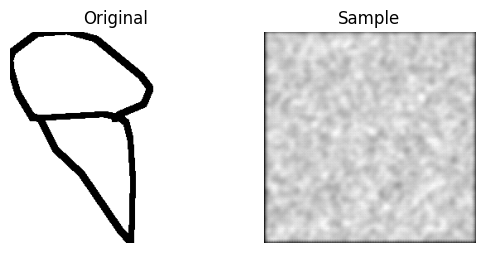

In [ ]:
Ls_train, Ls_val = train(model, train_loader, val_loader, config)


In [ ]:
n_samples = 12
rows, cols = 3, 4

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

for i in range(n_samples):
    img = model.sample()                # (1, 1, H, W) logits
    img = torch.sigmoid(img)            # convert logits → probabilities
    img = img.squeeze().detach().cpu().numpy()
    img = img > 0.65

    ax = axes[i // cols, i % cols]
    ax.imshow(img, cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()

